## **CAMOUFLAGE OBJECT DETECTION USING UNET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random

## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
w, h = 256,256
border = 5

# **Data Reading and Train test split**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import glob
train = sorted(glob.glob("/content/drive/MyDrive/Military_Dataset/train/images/*.jpg"))
test = sorted(glob.glob("/content/drive/MyDrive/Military_Dataset/test/images/*.jpg"))
train_mask = sorted(glob.glob("/content/drive/MyDrive/Military_Dataset/train/GT/*.jpg"))
test_mask = sorted(glob.glob("/content/drive/MyDrive/Military_Dataset/test/GT/*.png"))

train = sorted(train + test)
train_mask = sorted(train_mask + test_mask)

print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 1078
Total Mask Image : 1078


In [ ]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

0it [00:00, ?it/s]

In [ ]:
# # Save the files in Numpy array for reusability
# np.save('/content/drive/MyDrive/Military_Dataset/X.npy', X)
# np.save('/content/drive/MyDrive/Military_Dataset/y.npy', y)
# print(X.shape, y.shape)
X = np.load('/content/drive/MyDrive/Military_Dataset/X.npy')
y = np.load('/content/drive/MyDrive/Military_Dataset/y.npy')
print(X.shape, y.shape)

(1078, 256, 256, 3) (1078, 256, 256, 1)


In [ ]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(970, 256, 256, 3) (970, 256, 256, 1) (108, 256, 256, 3) (108, 256, 256, 1)


22

# **Visualization the image and It masks**

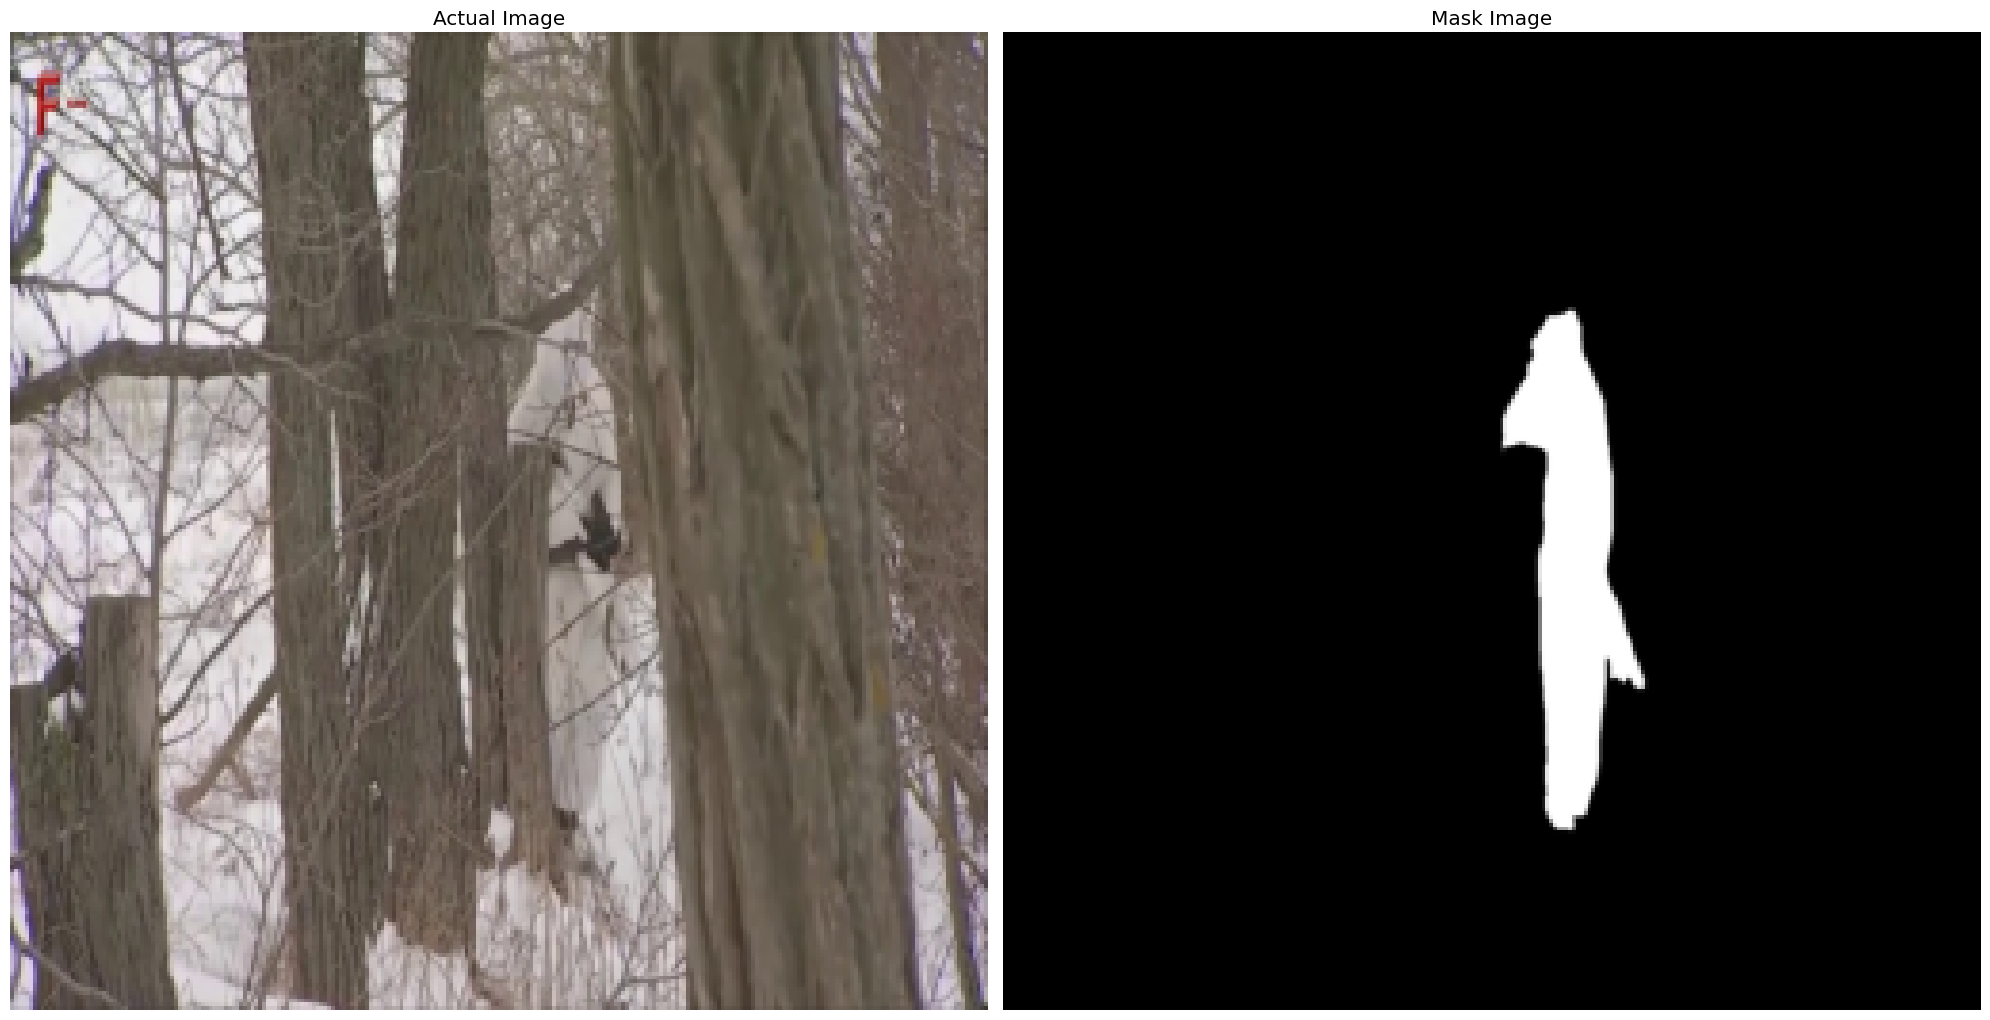

In [ ]:
import matplotlib.pyplot as plt

ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

# Check for grayscale image and handle channels accordingly
if len(X_train.shape) == 3 and X_train.shape[2] == 3:
    ax1.imshow(X_train[ix])
else:
    ax1.imshow(X_train[ix], cmap='gray')

# if has_mask:
#     ax1.contour(y_train[ix].squeeze(), colors='k', linewidths=5, levels=[0.5])

ax1.set_title('Actual Image')
ax1.set_axis_off()

ax2.imshow(y_train[ix].squeeze(), cmap='gray')
ax2.set_title('Mask Image')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

## **TRAINING AND TESTING**

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
from keras import backend as K
K.clear_session()

input_img = Input((h, w, 3), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = ["accuracy",
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5),
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

253

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['img[0][0]']                 
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0][0

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=40, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/40
162/162 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.7110 - auc: 0.6717 - sensitivity_at_specificity: 0.7431 - specificity_at_sensitivity: 0.7354
Epoch 1: val_loss improved from inf to 2.07323, saving model to model-Unet.h5
162/162 [==============================] - 55s 141ms/step - loss: 0.4801 - accuracy: 0.7110 - auc: 0.6717 - sensitivity_at_specificity: 0.7431 - specificity_at_sensitivity: 0.7354 - val_loss: 2.0732 - val_accuracy: 0.4428 - val_auc: 0.7745 - val_sensitivity_at_specificity: 0.8629 - val_specificity_at_sensitivity: 0.8627 - lr: 0.0010
Epoch 2/40
162/162 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.7746 - auc: 0.7841 - sensitivity_at_specificity: 0.8435 - specificity_at_sensitivity: 0.8962
Epoch 2: val_loss improved from 2.07323 to 0.55378, saving model to model-Unet.h5
162/162 [==============================] - 17s 106ms/step - loss: 0.3515 - accuracy: 0.7746 - auc: 0.7841 - sensitivity_at_specificity: 0

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

loss  accuracy       auc  sensitivity_at_specificity  \
12  0.248525  0.815372  0.852236                    0.893489   
22  0.157538  0.853796  0.893685                    0.898100   
19  0.169639  0.849908  0.886870                    0.900866   
20  0.162344  0.852322  0.891602                    0.901972   
15  0.226217  0.825466  0.866475                    0.899113   
21  0.160101  0.853192  0.894114                    0.901662   
18  0.183682  0.842698  0.881877                    0.903674   
10  0.263635  0.809249  0.846997                    0.886369   
8   0.276625  0.803540  0.838355                    0.883032   
16  0.221238  0.826205  0.867893                    0.891896   
13  0.241092  0.817467  0.855931                    0.887504   
6   0.287058  0.799565  0.829954                    0.876531   
11  0.258930  0.811248  0.846395                    0.883235   
5   0.296704  0.794258  0.829718                    0.879093   
7   0.280086  0.802097  0.836600                    0.886519   
2   0.326748  0.784586  0.802745                    0.861547   
17  0.209886  0.832010  0.872888                    0.906261   
4   0.302257  0.793552  0.819829                    0.873449   
9   0.269990  0.806356  0.838278                    0.885038   
14  0.232260  0.822032  0.863473                    0.900421   
3   0.319119  0.786875  0.807647                    0.862386   
1   0.351540  0.774646  0.784142                    0.843507   
0   0.480108  0.710981  0.671656                    0.743064   

    specificity_at_sensitivity  val_loss  val_accuracy   val_auc  \
12                    0.962725  0.248409      0.840835  0.881482   
22                    0.992169  0.254342      0.840434  0.879133   
19                    0.990333  0.257237      0.840468  0.876655   
20                    0.991468  0.257966      0.841210  0.877147   
15                    0.972728  0.258005      0.834366  0.874300   
21                    0.991758  0.262201      0.841261  0.875818   
18                    0.986931  0.263941      0.837905  0.873703   
10                    0.955754  0.281180      0.828143  0.854786   
8                     0.947625  0.284716      0.826527  0.851987   
16                    0.973395  0.286676      0.818333  0.860697   
13                    0.964848  0.289225      0.829160  0.867801   
6                     0.941460  0.299567      0.822073  0.852020   
11                    0.957431  0.303878      0.812555  0.841034   
5                     0.933356  0.314556      0.812617  0.850399   
7                     0.944918  0.327702      0.803271  0.828749   
2                     0.912661  0.328912      0.800994  0.839137   
17                    0.977848  0.336334      0.819058  0.851763   
4                     0.931806  0.371861      0.770711  0.857656   
9                     0.951285  0.380016      0.775830  0.854530   
14                    0.969423  0.386569      0.810653  0.842312   
3                     0.919072  0.427850      0.740777  0.851542   
1                     0.896239  0.553781      0.701914  0.827043   
0                     0.735437  2.073231      0.442824  0.774534   

    val_sensitivity_at_specificity  val_specificity_at_sensitivity      lr  
12                        0.923465                        0.975205  0.0010  
22                        0.897625                        0.972555  0.0001  
19                        0.902232                        0.973667  0.0001  
20                        0.903649                        0.973832  0.0001  
15                        0.920677                        0.965159  0.0010  
21                        0.889587                        0.973893  0.0001  
18                        0.905304                        0.973438  0.0001  
10                        0.910303                        0.957697  0.0010  
8                         0.888802                        0.957263  0.0010  
16                        0.909450                        0.962873  

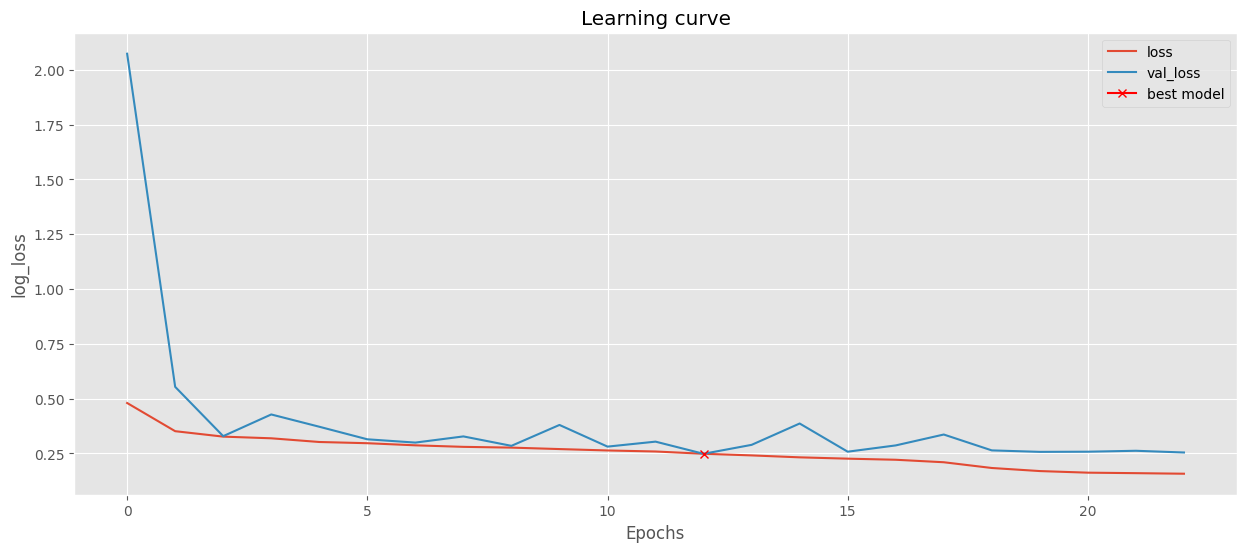

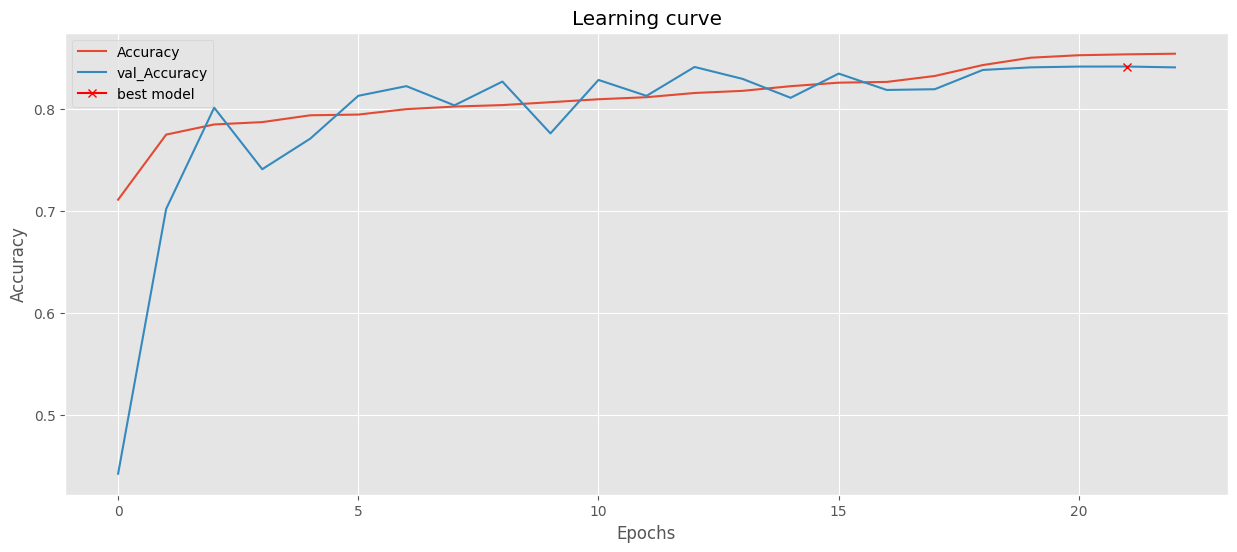

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [ ]:
model.load_weights('model-Unet_latest.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

4/4 [==============================] - 28s 7s/step - loss: 0.2484 - accuracy: 0.8408 - auc: 0.8815 - sensitivity_at_specificity: 0.9235 - specificity_at_sensitivity: 0.9752


[0.24840879440307617,
 0.8408352732658386,
 0.8814816474914551,
 0.9234652519226074,
 0.9752055406570435]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

4/4 [==============================] - 27s 6s/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Actual Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title(" Image Predicted")
    ax[2].set_axis_off()

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Mask Image Predicted binary');
    ax[3].set_axis_off()
    print("Dice Coefficient: " , get_dice(y[ix].squeeze(),binary_preds[ix].squeeze()))

In [ ]:
def get_dice(mask1, mask2):
    mask1 = mask1.flatten()
    mask2 = mask2.flatten()
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice

Dice Coefficient:  0.737


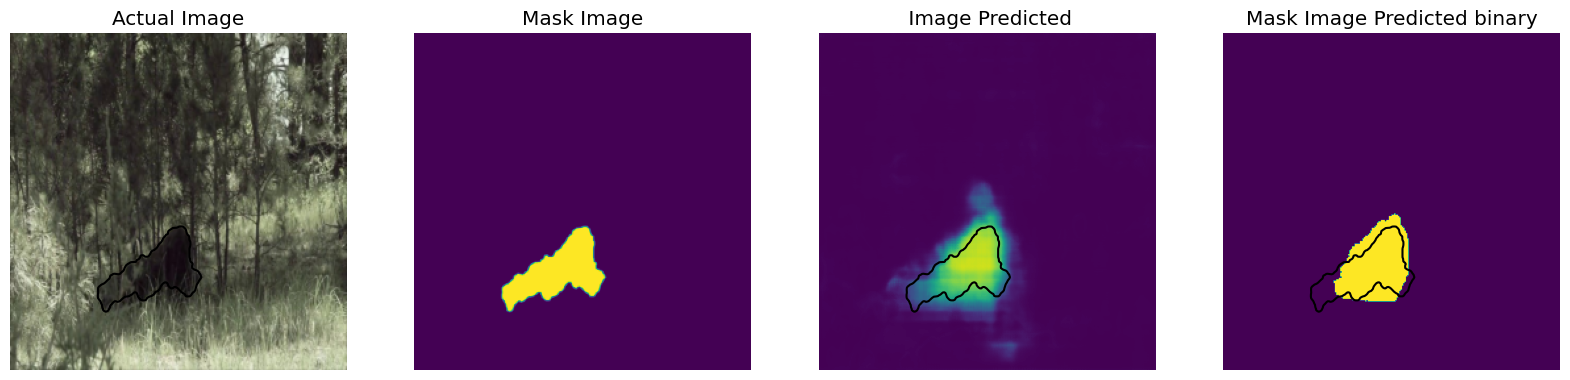

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

Dice Coefficient:  0.688


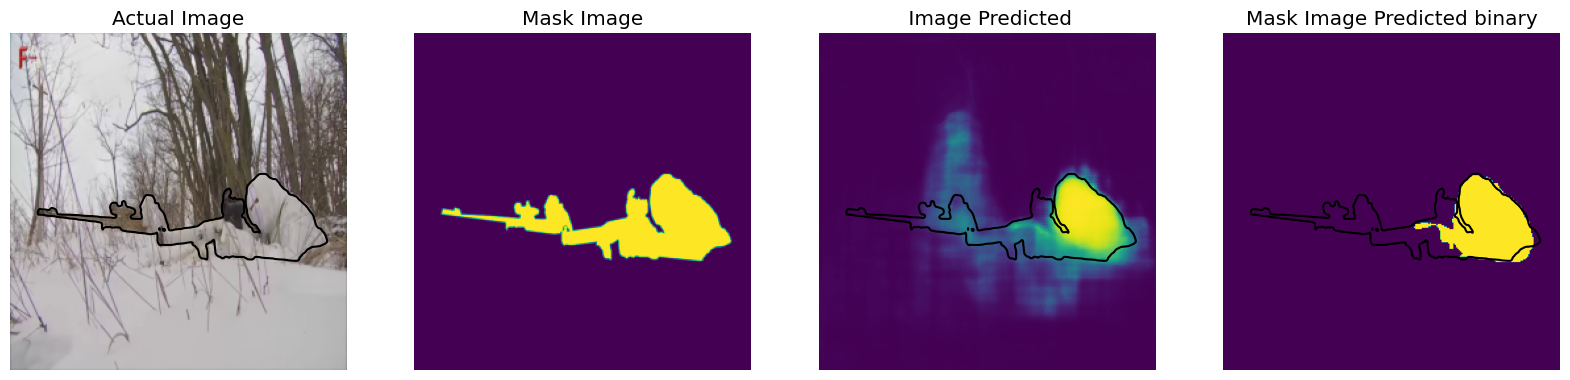

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

Dice Coefficient:  0.739


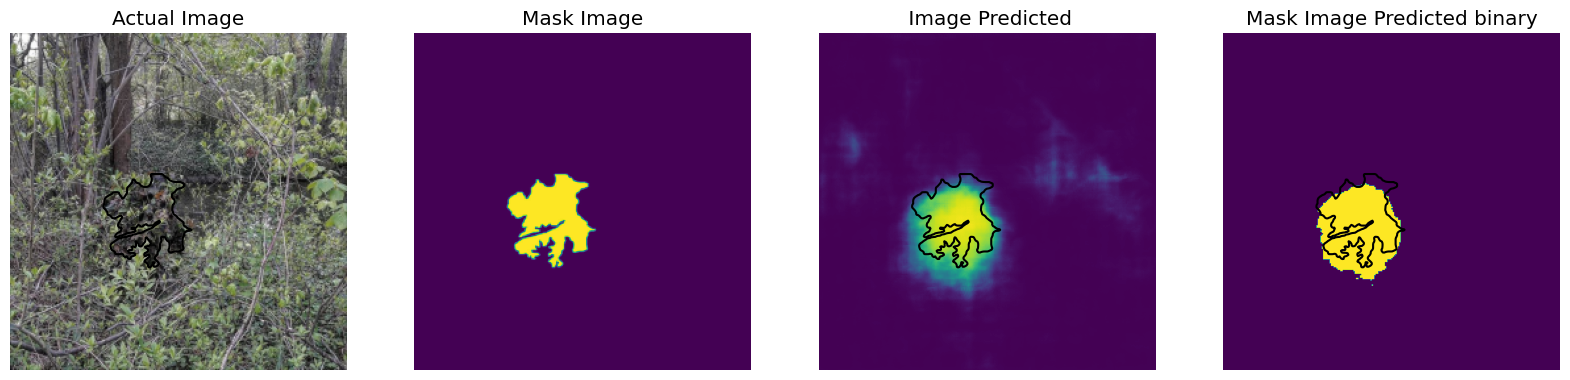

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

Dice Coefficient:  0.436


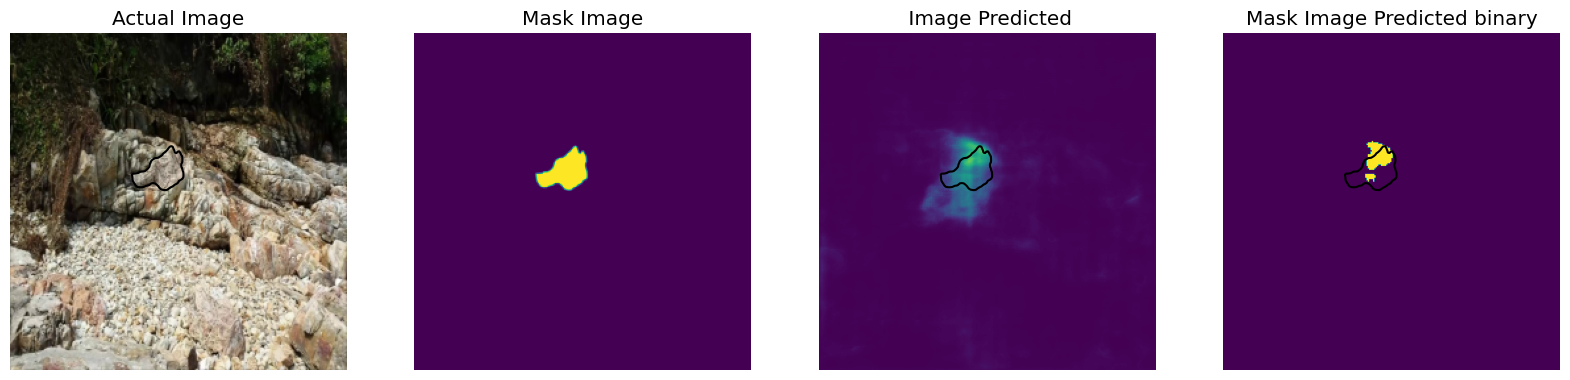

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

Dice Coefficient:  0.908


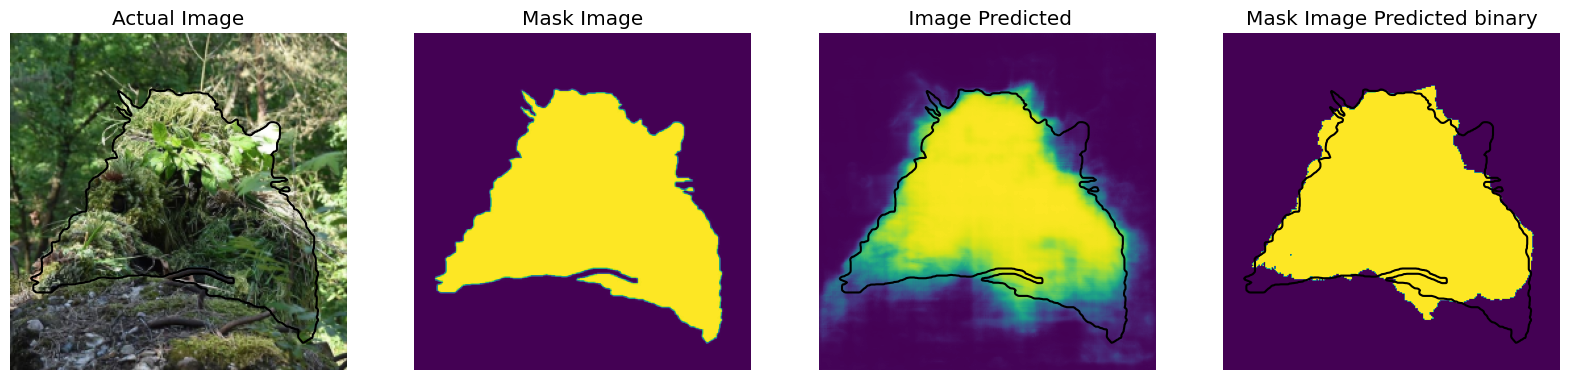

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

Dice Coefficient:  0.934


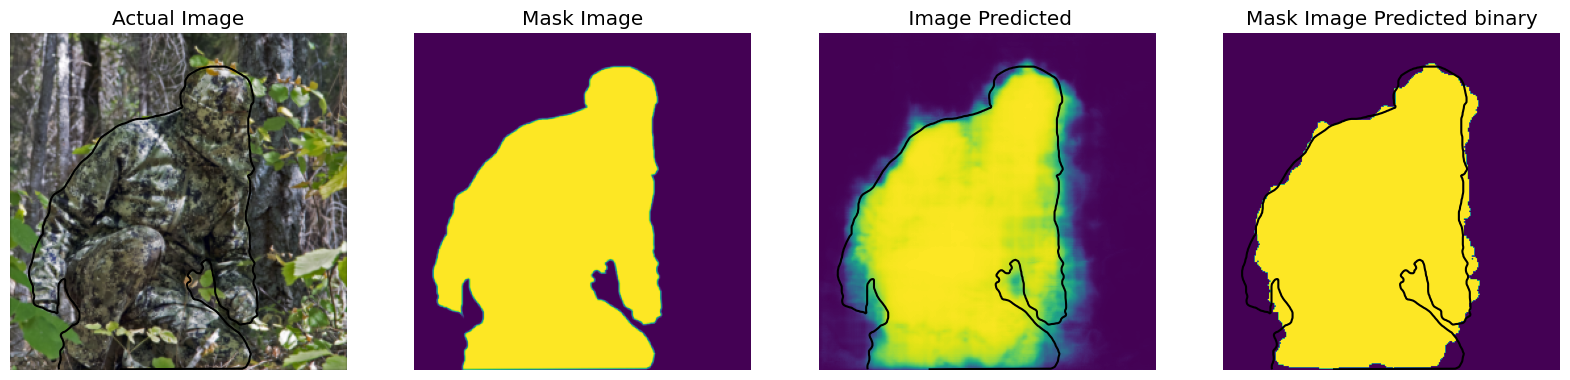

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

Dice Coefficient:  0.426


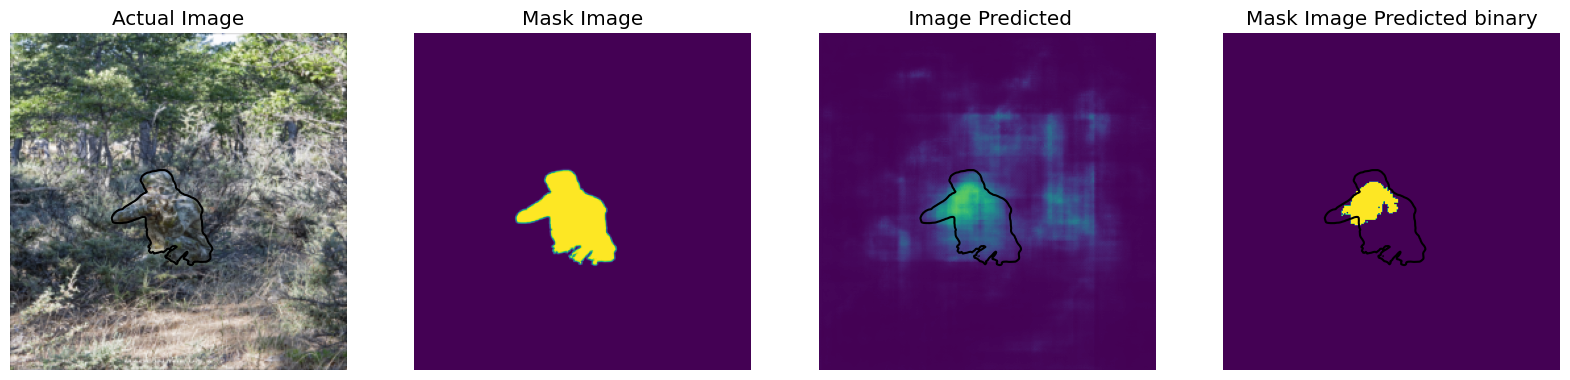

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Testing actual real images from google

# Testing Random Camouflaged Militant image from Google

In [ ]:
img = load_img("/content/drive/MyDrive/Military_Dataset/real_data.jpg")
x_img = img_to_array(img)
x_img = resize(x_img, (256, 256, 3), mode = 'constant', preserve_range = True)
x_img =x_img/255.0

In [ ]:
x_img.shape

(256, 256, 3)

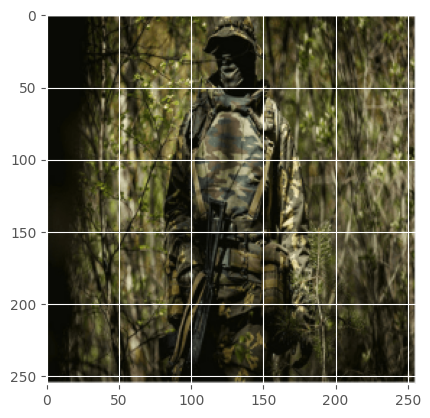

In [ ]:
plt.imshow(x_img)
plt.show()

In [ ]:
dataset1 = tf.data.Dataset.from_tensor_slices([x_img]).batch(32)

In [ ]:
real_test = model.predict(dataset1, verbose=1)
# model.input_shape

1/1 [==============================] - 1s 1s/step


In [ ]:
binary = (real_test > 0.5).astype(np.uint8)

Dice Coefficient:  0.873


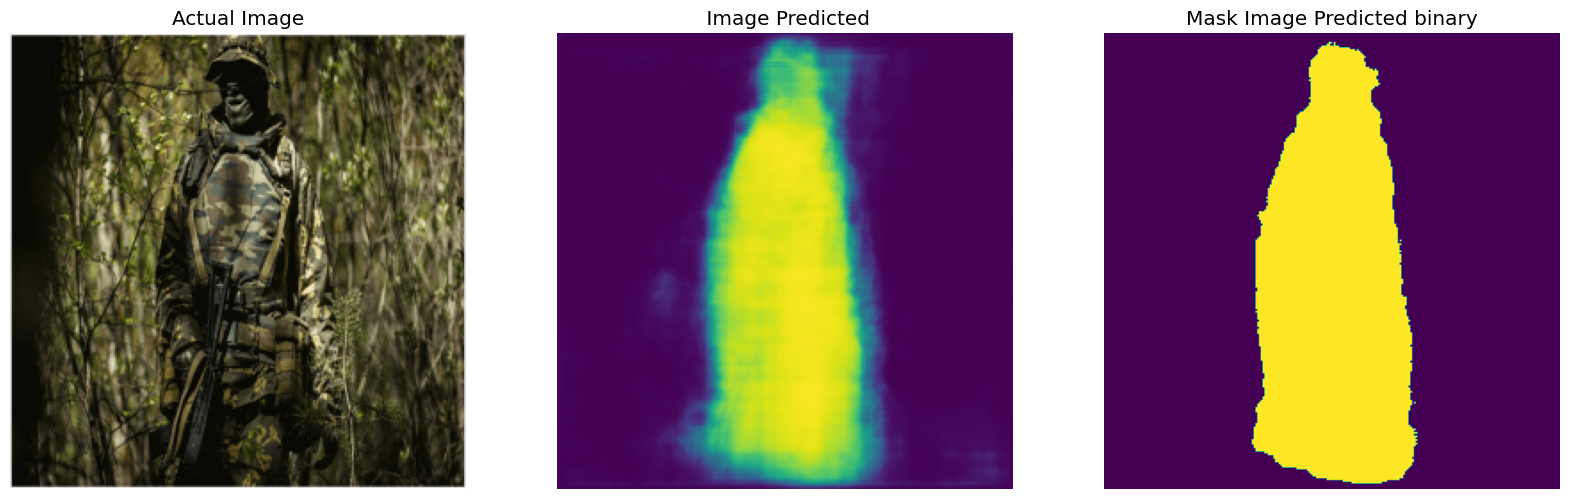

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(x_img)
ax[0].set_title('Actual Image')
ax[0].set_axis_off()

ax[1].imshow(real_test.squeeze(), vmin=0, vmax=1)
# if has_mask:
#     ax[1].contour(real_test.squeeze(), colors='k', levels=[0.5])
ax[1].set_title(" Image Predicted")
ax[1].set_axis_off()

ax[2].imshow(binary.squeeze(), vmin=0, vmax=1)
# if has_mask:
#     ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
ax[2].set_title('Mask Image Predicted binary');
ax[2].set_axis_off()
print("Dice Coefficient: " , get_dice(real_test.squeeze(),binary.squeeze()))